In [50]:
from scipy import stats
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

np.set_printoptions(threshold=np.inf)

In [51]:
cols_to_drop = ['type', 'tas', 'cas', 'vs', 'gs', 'Temp', 'trk', 'hdg', 'p', 'rho', 'thrust', 'drag', 'phase', 'fuelflow']
# observed time to reach maximum altitude with drone (in seconds)
time_to_reach_max_alt = 7

#observed time to reach final altitude with drone from max altitude (in seconds)
time_to_reach_min_alt = 8

# guessed delivery time for package to be dropped/lowered (in seconds). This is just an approximation so it could be higher or lower in reality.
delivery_time = 20

In [52]:
df = pd.read_csv('data.csv')

In [53]:
df.head()

,simt,id,type,lat,lon,alt,tas,cas,vs,gs,distflown,Temp,trk,hdg,p,rho,thrust,drag,phase,fuelflow
0,0.0,0,M600,4.665970,-74.055580,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,103.682755,103.682755,101288.381045,1.224641,0.0,0.0,0.0,0.0
1,0.0,1,M600,4.665970,-74.055580,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,76.194480,76.194480,101288.381045,1.224641,0.0,0.0,0.0,0.0
2,0.0,7,M600,4.665970,-74.055580,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,159.892422,159.892422,101288.381045,1.224641,0.0,0.0,0.0,0.0
3,0.0,9,M600,4.722692,-74.062403,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,3.128205,3.128205,101288.381045,1.224641,0.0,0.0,0.0,0.0
4,0.0,12,M600,4.722692,-74.062403,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,340.849025,340.849025,101288.381045,1.224641,0.0,0.0,0.0,0.0


In [54]:
df.dtypes

simt         float64
id             int64
type          object
lat          float64
lon          float64
alt          float64
tas          float64
cas          float64
vs           float64
gs           float64
distflown    float64
Temp         float64
trk          float64
hdg          float64
p            float64
rho          float64
thrust       float64
drag         float64
phase        float64
fuelflow     float64
dtype: object

In [55]:
df.isnull().sum()

simt         0
id           0
type         0
lat          0
lon          0
alt          0
tas          0
cas          0
vs           0
gs           0
distflown    0
Temp         0
trk          0
hdg          0
p            0
rho          0
thrust       0
drag         0
phase        0
fuelflow     0
dtype: int64

In [56]:
df_start = df.sort_values(by=['id', 'simt'], ascending=True)
df_start.tail(20)

,simt,id,type,lat,lon,alt,tas,cas,vs,gs,distflown,Temp,trk,hdg,p,rho,thrust,drag,phase,fuelflow
869197,163.0,19933,M600,4.631168,-74.072424,30.48000,10.014646,10.0,0.0000,8.475545,1387.542941,287.951880,92.338480,122.262623,100959.305895,1.221419,0.0,0.0,0.0,0.0
872669,164.0,19933,M600,4.631165,-74.072348,30.48000,10.014646,10.0,0.0000,8.475545,1396.018486,287.951880,92.338486,122.262629,100959.305895,1.221419,0.0,0.0,0.0,0.0
876113,165.0,19933,M600,4.631161,-74.072271,30.48000,10.014646,10.0,0.0000,8.475544,1404.494031,287.951880,92.338492,122.262635,100959.305895,1.221419,0.0,0.0,0.0,0.0
879538,166.0,19933,M600,4.631158,-74.072195,30.48000,10.014646,10.0,0.0000,8.475544,1412.969575,287.951880,92.338498,122.262641,100959.305895,1.221419,0.0,0.0,0.0,0.0
882945,167.0,19933,M600,4.631155,-74.072118,30.48000,10.014646,10.0,0.0000,8.475543,1421.445118,287.951880,92.338505,122.262647,100959.305895,1.221419,0.0,0.0,0.0,0.0
886332,168.0,19933,M600,4.631152,-74.072042,30.48000,10.014646,10.0,0.0000,8.475543,1429.920661,287.951880,92.338511,122.262653,100959.305895,1.221419,0.0,0.0,0.0,0.0
889693,169.0,19933,M600,4.631149,-74.071966,30.48000,10.014646,10.0,0.0000,8.475542,1438.396204,287.951880,92.338517,122.262659,100959.305895,1.221419,0.0,0.0,0.0,0.0
893038,170.0,19933,M600,4.631146,-74.071889,30.48000,10.014646,10.0,0.0000,8.475542,1446.871746,287.951880,92.338523,122.262665,100959.305895,1.221419,0.0,0.0,0.0,0.0
896366,171.0,19933,M600,4.631143,-74.071813,30.48000,10.014646,10.0,0.0000,8.475541,1455.347287,287.951880,92.338529,122.262671,100959.305895,1.221419,0.0,0.0,0.0,0.0
899671,172.0,19933,M600,4.631140,-74.071736,30.48000,10.014646,10.0,0.0000,8.475541,1463.822828,287.951880,92.338536,122.262678,100959.305895,1.221419,0.0,0.0,0.0,0.0


In [57]:
df_start = df.sort_values(by=['id', 'simt'], ascending=True).drop_duplicates('id').sort_values('id')
df_start

,simt,id,type,lat,lon,alt,tas,cas,vs,gs,distflown,Temp,trk,hdg,p,rho,thrust,drag,phase,fuelflow
0,0.0,0,M600,4.665970,-74.055580,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,103.682755,103.682755,101288.381045,1.224641,0.0,0.0,0.0,0.0
1,0.0,1,M600,4.665970,-74.055580,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,76.194480,76.194480,101288.381045,1.224641,0.0,0.0,0.0,0.0
2,0.0,7,M600,4.665970,-74.055580,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,159.892422,159.892422,101288.381045,1.224641,0.0,0.0,0.0,0.0
3,0.0,9,M600,4.722692,-74.062403,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,3.128205,3.128205,101288.381045,1.224641,0.0,0.0,0.0,0.0
4,0.0,12,M600,4.722692,-74.062403,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,340.849025,340.849025,101288.381045,1.224641,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6906,0.0,19922,M600,4.714166,-74.070364,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,179.815436,179.815436,101288.381045,1.224641,0.0,0.0,0.0,0.0
6907,0.0,19923,M600,4.714166,-74.070364,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,0.623954,0.623954,101288.381045,1.224641,0.0,0.0,0.0,0.0
6908,0.0,19931,M600,4.631854,-74.084877,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,113.953021,113.953021,101288.381045,1.224641,0.0,0.0,0.0,0.0
6909,0.0,19932,M600,4.631854,-74.084877,3.048,10.001463,10.0,0.0,10.001463,0.0,288.130188,317.254540,317.254540,101288.381045,1.224641,0.0,0.0,0.0,0.0


In [58]:
df_end = df.sort_values(by=['id', 'simt'], ascending=False).drop_duplicates('id').sort_values('id').reset_index()
df_end

,index,simt,id,type,lat,lon,alt,tas,cas,vs,...,distflown,Temp,trk,hdg,p,rho,thrust,drag,phase,fuelflow
0,928565,182.0,0,M600,4.665716,-74.041322,4.36139,10.002214,10.0,-5.0,...,1587.298833,288.120026,109.761002,109.761002,101269.603259,1.224458,0.0,0.0,0.0,0.0
1,1012705,212.0,1,M600,4.666067,-74.038788,4.11139,10.002094,10.0,-5.0,...,1866.545756,288.121651,108.264930,108.264930,101272.605805,1.224487,0.0,0.0,0.0,0.0
2,902960,174.0,7,M600,4.664200,-74.042936,2.11139,10.001134,10.0,-5.0,...,1424.796900,288.134651,114.753385,114.753385,101296.628768,1.224722,0.0,0.0,0.0,0.0
3,783632,141.0,9,M600,4.725562,-74.074538,0.11139,10.000173,10.0,-5.0,...,1393.712467,288.147651,272.132743,272.132743,101320.656346,1.224957,0.0,0.0,0.0,0.0
4,1050421,228.0,12,M600,4.723181,-74.044542,4.61139,10.002334,10.0,-5.0,...,2004.804534,288.118401,109.169982,109.169982,101266.600785,1.224428,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6906,882942,167.0,19922,M600,4.712707,-74.082644,4.11139,10.002094,10.0,-5.0,...,1385.005094,288.121651,244.518434,244.518434,101272.605805,1.224487,0.0,0.0,0.0,0.0
6907,473371,74.0,19923,M600,4.716977,-74.076913,3.86139,10.001974,10.0,-5.0,...,798.015710,288.123276,279.489176,279.489176,101275.608423,1.224516,0.0,0.0,0.0,0.0
6908,964527,193.0,19931,M600,4.631204,-74.069977,1.36139,10.000773,10.0,-5.0,...,1660.365045,288.139526,107.829711,107.829711,101305.638569,1.224810,0.0,0.0,0.0,0.0
6909,1202459,344.0,19932,M600,4.634112,-74.113056,2.61139,10.001374,10.0,-5.0,...,3138.753234,288.131401,258.085159,258.085159,101290.622595,1.224663,0.0,0.0,0.0,0.0


In [59]:
df_start = df_start.drop(columns=cols_to_drop)
df_start

,simt,id,lat,lon,alt,distflown
0,0.0,0,4.665970,-74.055580,3.048,0.0
1,0.0,1,4.665970,-74.055580,3.048,0.0
2,0.0,7,4.665970,-74.055580,3.048,0.0
3,0.0,9,4.722692,-74.062403,3.048,0.0
4,0.0,12,4.722692,-74.062403,3.048,0.0
...,...,...,...,...,...,...
6906,0.0,19922,4.714166,-74.070364,3.048,0.0
6907,0.0,19923,4.714166,-74.070364,3.048,0.0
6908,0.0,19931,4.631854,-74.084877,3.048,0.0
6909,0.0,19932,4.631854,-74.084877,3.048,0.0


In [60]:
df_end = df_end.drop(columns=cols_to_drop)
df_end

,index,simt,id,lat,lon,alt,distflown
0,928565,182.0,0,4.665716,-74.041322,4.36139,1587.298833
1,1012705,212.0,1,4.666067,-74.038788,4.11139,1866.545756
2,902960,174.0,7,4.664200,-74.042936,2.11139,1424.796900
3,783632,141.0,9,4.725562,-74.074538,0.11139,1393.712467
4,1050421,228.0,12,4.723181,-74.044542,4.61139,2004.804534
...,...,...,...,...,...,...,...
6906,882942,167.0,19922,4.712707,-74.082644,4.11139,1385.005094
6907,473371,74.0,19923,4.716977,-74.076913,3.86139,798.015710
6908,964527,193.0,19931,4.631204,-74.069977,1.36139,1660.365045
6909,1202459,344.0,19932,4.634112,-74.113056,2.61139,3138.753234


In [61]:
df = df_end.join(df_start, lsuffix='_final', rsuffix='_init')
df = df.rename(columns={"simt_final": "simt", "id_final": "id", "distflown_final": "distflown"})
df = df.drop(columns=['index', 'simt_init', 'id_init', 'distflown_init'])

df['lat_dist'] = abs(df['lat_final'] - df['lat_init'])
df['lon_dist'] = abs(df['lon_final'] - df['lon_init'])
df['alt_dist'] = abs(df['alt_final'] - df['alt_init'])
df

,simt,id,lat_final,lon_final,alt_final,distflown,lat_init,lon_init,alt_init,lat_dist,lon_dist,alt_dist
0,182.0,0,4.665716,-74.041322,4.36139,1587.298833,4.665970,-74.055580,3.048,0.000254,0.014258,1.31339
1,212.0,1,4.666067,-74.038788,4.11139,1866.545756,4.665970,-74.055580,3.048,0.000097,0.016792,1.06339
2,174.0,7,4.664200,-74.042936,2.11139,1424.796900,4.665970,-74.055580,3.048,0.001770,0.012644,0.93661
3,141.0,9,4.725562,-74.074538,0.11139,1393.712467,4.722692,-74.062403,3.048,0.002870,0.012135,2.93661
4,228.0,12,4.723181,-74.044542,4.61139,2004.804534,4.722692,-74.062403,3.048,0.000489,0.017861,1.56339
...,...,...,...,...,...,...,...,...,...,...,...,...
6906,167.0,19922,4.712707,-74.082644,4.11139,1385.005094,4.714166,-74.070364,3.048,0.001459,0.012280,1.06339
6907,74.0,19923,4.716977,-74.076913,3.86139,798.015710,4.714166,-74.070364,3.048,0.002811,0.006549,0.81339
6908,193.0,19931,4.631204,-74.069977,1.36139,1660.365045,4.631854,-74.084877,3.048,0.000650,0.014900,1.68661
6909,344.0,19932,4.634112,-74.113056,2.61139,3138.753234,4.631854,-74.084877,3.048,0.002258,0.028179,0.43661


Used to check that we have all Ids accounted for

In [62]:
df.nunique()

simt          463
id           6911
lat_final    6911
lon_final    6910
alt_final      74
distflown    6908
lat_init      815
lon_init      816
alt_init        1
lat_dist     6877
lon_dist     6903
alt_dist       74
dtype: int64

In [63]:
id_list = df.id.unique()
len(id_list)

6911

In [64]:
id_count = df['id'].value_counts(sort=False).tolist()
len(id_count)

6911

In [65]:
df['avg_speed'] = df['distflown'] / df['simt']

In [66]:
df

,simt,id,lat_final,lon_final,alt_final,distflown,lat_init,lon_init,alt_init,lat_dist,lon_dist,alt_dist,avg_speed
0,182.0,0,4.665716,-74.041322,4.36139,1587.298833,4.665970,-74.055580,3.048,0.000254,0.014258,1.31339,8.721422
1,212.0,1,4.666067,-74.038788,4.11139,1866.545756,4.665970,-74.055580,3.048,0.000097,0.016792,1.06339,8.804461
2,174.0,7,4.664200,-74.042936,2.11139,1424.796900,4.665970,-74.055580,3.048,0.001770,0.012644,0.93661,8.188488
3,141.0,9,4.725562,-74.074538,0.11139,1393.712467,4.722692,-74.062403,3.048,0.002870,0.012135,2.93661,9.884486
4,228.0,12,4.723181,-74.044542,4.61139,2004.804534,4.722692,-74.062403,3.048,0.000489,0.017861,1.56339,8.793002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6906,167.0,19922,4.712707,-74.082644,4.11139,1385.005094,4.714166,-74.070364,3.048,0.001459,0.012280,1.06339,8.293444
6907,74.0,19923,4.716977,-74.076913,3.86139,798.015710,4.714166,-74.070364,3.048,0.002811,0.006549,0.81339,10.783996
6908,193.0,19931,4.631204,-74.069977,1.36139,1660.365045,4.631854,-74.084877,3.048,0.000650,0.014900,1.68661,8.602928
6909,344.0,19932,4.634112,-74.113056,2.61139,3138.753234,4.631854,-74.084877,3.048,0.002258,0.028179,0.43661,9.124283


<Axes: xlabel='simt', ylabel='avg_speed'>

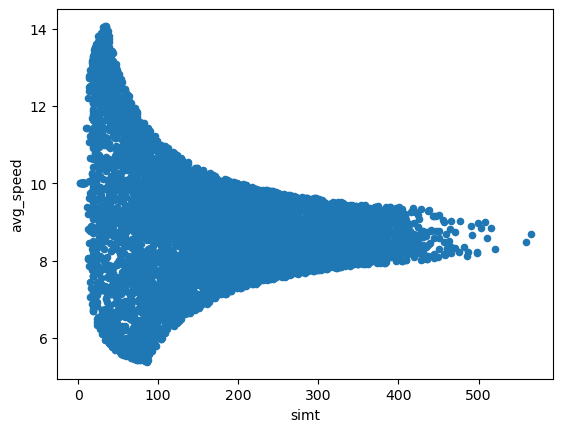

In [67]:
df.plot('simt', 'avg_speed', kind='scatter')

<Axes: xlabel='distflown', ylabel='avg_speed'>

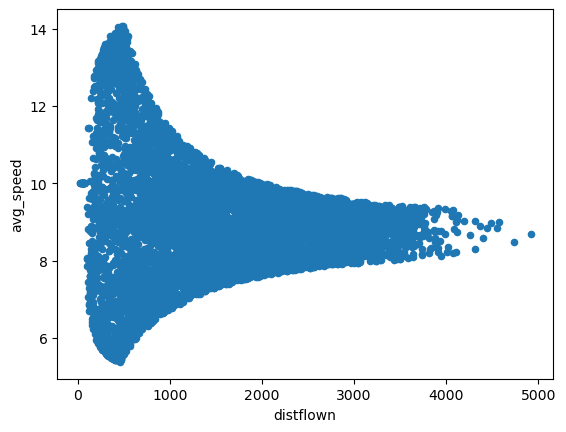

In [68]:
df.plot('distflown', 'avg_speed', kind='scatter')

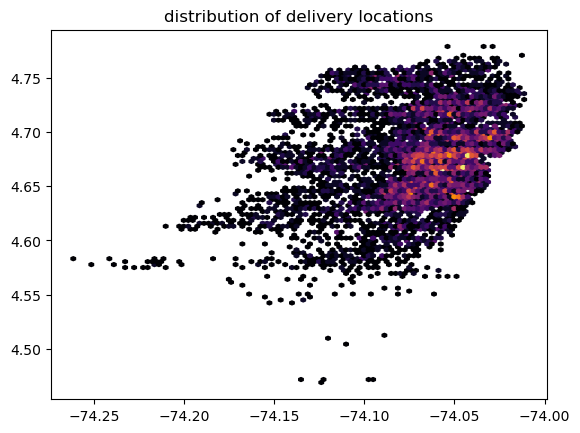

In [69]:
coll = plt.hexbin(x='lon_final', y='lat_final', data=df, gridsize=100, cmap="inferno", mincnt=1)
plt.title("distribution of delivery locations")
plt.show()

In [77]:
step = 0.01
to_bin = lambda x: np.floor(x / step) * step
df["latBin"] = to_bin(df.lat_final)
df["lonBin"] = to_bin(df.lon_final)
groups = df.groupby(["latBin", "lonBin"])['id'].count()

In [81]:
groups

latBin  lonBin
4.46    -74.13     1
4.47    -74.14     1
        -74.13     1
        -74.10     2
4.50    -74.13     1
                  ..
4.76    -74.03    11
4.77    -74.06     1
        -74.04     1
        -74.03     1
        -74.02     1
Name: id, Length: 320, dtype: int64

In [ ]:
df

,simt,id,lat_final,lon_final,alt_final,distflown,lat_init,lon_init,alt_init,lat_dist,lon_dist,alt_dist,avg_speed,latBin,lonBin
0,182.0,0,4.665716,-74.041322,4.36139,1587.298833,4.665970,-74.055580,3.048,0.000254,0.014258,1.31339,8.721422,4.66,-74.05
1,212.0,1,4.666067,-74.038788,4.11139,1866.545756,4.665970,-74.055580,3.048,0.000097,0.016792,1.06339,8.804461,4.66,-74.04
2,174.0,7,4.664200,-74.042936,2.11139,1424.796900,4.665970,-74.055580,3.048,0.001770,0.012644,0.93661,8.188488,4.66,-74.05
3,141.0,9,4.725562,-74.074538,0.11139,1393.712467,4.722692,-74.062403,3.048,0.002870,0.012135,2.93661,9.884486,4.72,-74.08
4,228.0,12,4.723181,-74.044542,4.61139,2004.804534,4.722692,-74.062403,3.048,0.000489,0.017861,1.56339,8.793002,4.72,-74.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6906,167.0,19922,4.712707,-74.082644,4.11139,1385.005094,4.714166,-74.070364,3.048,0.001459,0.012280,1.06339,8.293444,4.71,-74.09
6907,74.0,19923,4.716977,-74.076913,3.86139,798.015710,4.714166,-74.070364,3.048,0.002811,0.006549,0.81339,10.783996,4.71,-74.08
6908,193.0,19931,4.631204,-74.069977,1.36139,1660.365045,4.631854,-74.084877,3.048,0.000650,0.014900,1.68661,8.602928,4.63,-74.07
6909,344.0,19932,4.634112,-74.113056,2.61139,3138.753234,4.631854,-74.084877,3.048,0.002258,0.028179,0.43661,9.124283,4.63,-74.12


In [ ]:
df['demand'] = 

SyntaxError: invalid syntax (1863292646.py, line 1)

<Axes: xlabel='lonBin', ylabel='latBin'>

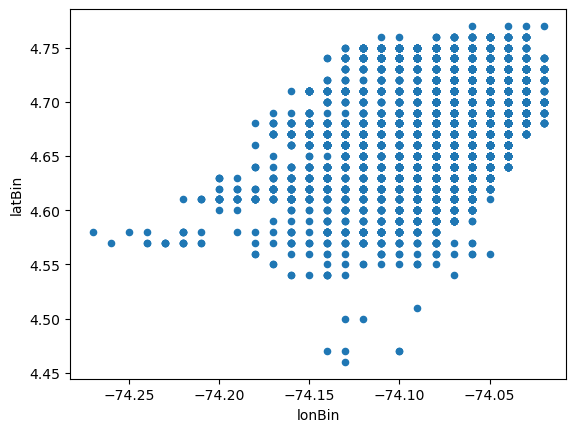

In [ ]:
df.plot('lonBin', 'latBin', kind='scatter')

In [ ]:
trainX = df
trainY = df['delay']

X_train, X_test, y_train, y_test = train_test_split(trainX,trainY,test_size=0.2, random_state=0)

KeyError: 'delay'

In [ ]:
clf = svm.SVR()
clf1 = RandomForestClassifier()
clf2 = RandomForestRegressor()
clf = clf.fit(X_train, y_train)
clf1 = clf1.fit(X_train, y_train)
clf2 = clf2.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [ ]:
y_train_pred = clf.predict(X_test)
y_train_pred1 = clf1.predict(X_test)
y_train_pred2 = clf2.predict(X_test)

NameError: name 'X_test' is not defined

In [ ]:
clf.score(X_test, y_train_pred)
clf1.score(X_test, y_train_pred1)
clf2.score(X_test, y_train_pred2)

NameError: name 'X_test' is not defined

In [ ]:
y_pred = clf.predict(testX)
y_pred1 = clf1.predict(testX)
y_pred2 = clf2.predict(testX)

NameError: name 'testX' is not defined

In [ ]:
clf.score(testX, y_pred)
clf1.score(testX, y_pred1)
clf2.score(testX, y_pred2)

NameError: name 'testX' is not defined

NameError: name 'X_train' is not defined

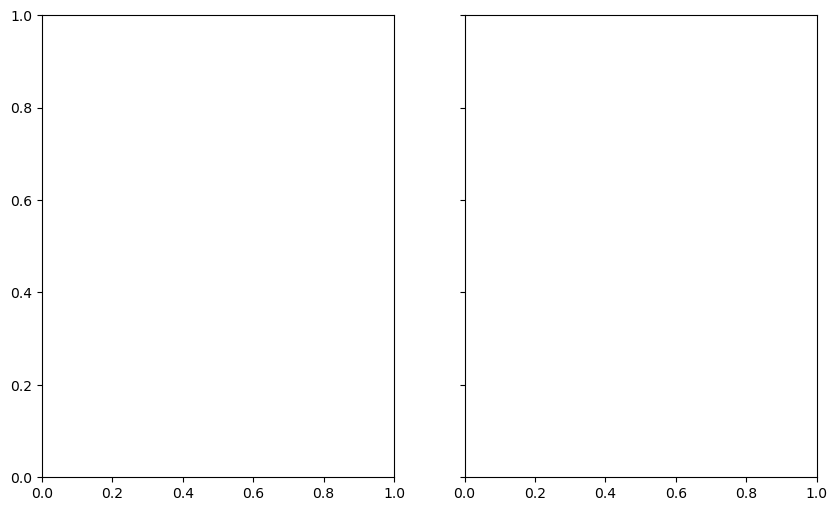

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([clf]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([clf1]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

: 

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

for ax_idx, estimator in enumerate([clf2]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

: 